# Network Model - Analysis

In [1]:
# Libraries
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from auxiliar_funcs import *
import matplotlib.pyplot as plt
from collections import Counter
from aux_network import build_network_model, bipartite_projection
from aux_plot import calculate_log_binning
from aux_coms import sub_community_detection, add_type_commts
from math import log2, ceil

### Load Data

In [2]:
# LOAD DATA
url_file = "../00-Data/train.csv"
df_data = pd.read_csv(url_file)
print("Data loaded!")
print(df_data.info())

# User attributes
user_attrs = df_data.columns[2:]

# Number of users
n_users = len(df_data[user_attrs].drop_duplicates())
n_rsrcs = len(df_data.RESOURCE.drop_duplicates())
print("|U|: ", n_users) # Unique users
print("|R|: ", n_rsrcs) # Unique resources

# Create an index for every users
user_dict = {}
for u_idx, u_attr in enumerate(df_data[user_attrs].drop_duplicates().values):
    idx = "999" + str(u_idx) + "999"
    user_dict[int(idx)] = list(u_attr)
print("|U| :", len(user_dict))

# Create a new column to add in a DF
list_usr_idx = []
key_list = list(user_dict.keys()) # list out keys and values separately
val_list = list(user_dict.values())
for log in df_data[user_attrs].values:
    key_idx = val_list.index(list(log))
    list_usr_idx.append(key_list[key_idx])
print("|L'| :", len(list_usr_idx), " = |L| :", len(df_data))
df_data["USERID"] = list_usr_idx

print()
df_pos_entries = df_data[df_data.ACTION==1]
df_neg_entries = df_data[df_data.ACTION==0]
print('Num positive entries:',len(df_pos_entries), 
    "{:.4}%".format((len(df_pos_entries)/len(df_data))*100))
print('Num negative entries:',len(df_neg_entries),
    "{:.4}%".format((len(df_neg_entries)/len(df_data))*100))

##### ***** Cross-Validation Configuration ***** #####
k = 10
test_size = 0.2
kfold = StratifiedShuffleSplit(n_splits=k, test_size=test_size, random_state=1)

data_partition = kfold.split(df_data, df_data.ACTION)
data_corpus = [] # Lista donde se almacenan los k fols

for train_data, test_data in data_partition:        
    X_train, X_test = df_data.iloc[train_data], df_data.iloc[test_data]
    data_corpus.append([X_train, X_test])

print("Done!")

Data loaded!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB
None
|U|:  9561
|R|:  7518
|U| : 9561
|L'| : 32769  = |L| : 32769

Num positive entries: 30872 94.21%
Num negative entries: 1897 5.789%
Done!


### Data Pre-processing

In [3]:
##### ***** Control Variables ***** #####
id_kfold = 1
task4 = True
#########################################

df_train_k, df_test_k = data_corpus[id_kfold][0], data_corpus[id_kfold][1]
print("# Train access request =", len(df_train_k), 
      " %: {:.2f}".format((len(df_train_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Test access request =", len(df_test_k),
      " %: {:.2f}".format((len(df_test_k)/(len(df_train_k)+len(df_test_k)))*100))
print("# Total =", len(df_train_k)+len(df_test_k))
print()

##### ***** Task 1: Null and uknwokn values ***** #####
print("TASK 1: Done!"); print() # NA


##### ***** TASK 2: convert continuous values to categorical values ***** #####
print("TASK 2: Done!"); print() # NA 

##### ***** TASK 3: Drop duplicates access requests ***** #####
print("TASK 3: Drop duplicates access requests")
df_train_k_pos = df_train_k[df_train_k.ACTION==1]   # Train Pos
df_train_k_neg = df_train_k[df_train_k.ACTION==0]   # Train Neg
df_test_k_pos = df_test_k[df_test_k.ACTION==1]      # Test Pos
df_test_k_neg = df_test_k[df_test_k.ACTION==0]      # Test Neg
df_train_k_pos = df_train_k_pos[df_train_k_pos.columns[1:]].drop_duplicates()
df_train_k_neg = df_train_k_neg[df_train_k_neg.columns[1:]].drop_duplicates()
df_test_k_pos = df_test_k_pos[df_test_k_pos.columns[1:]].drop_duplicates()
df_test_k_neg = df_test_k_neg[df_test_k_neg.columns[1:]].drop_duplicates()
print()

print("# Solicitudes Train (+):", len(df_train_k_pos), " %: {:.2f}".format(
      (len(df_train_k_pos)/len(df_train_k))*100))
print("# Solicitudes Train (-):", len(df_train_k_neg), " %: {:.2f}".format(
      (len(df_train_k_neg)/len(df_train_k))*100))
print("# Solicitudes Test (+):", len(df_test_k_pos), " %: {:.2f}".format(
      (len(df_test_k_pos)/len(df_test_k))*100))
print("# Solicitudes Test (-):", len(df_test_k_neg), " %: {:.2f}".format(
      (len(df_test_k_neg)/len(df_test_k))*100))
print("# Train Users (+): ", len(df_train_k_pos.USERID.drop_duplicates()))
print("# Train Resrc (+): ", len(df_train_k_pos.RESOURCE.drop_duplicates()))
print("# Train Users (-): ", len(df_train_k_neg.USERID.drop_duplicates()))
print("# Train Resrc (-): ", len(df_train_k_neg.RESOURCE.drop_duplicates()))
print("# Test Users (+): ", len(df_test_k_pos.USERID.drop_duplicates()))
print("# Test Resrc (+): ", len(df_test_k_pos.RESOURCE.drop_duplicates()))
print("# Test Users (-): ", len(df_test_k_neg.USERID.drop_duplicates()))
print("# Test Resrc (-): ", len(df_test_k_neg.RESOURCE.drop_duplicates())); print()

if task4:
    # Filter resources
      n1 = 0
      n2 = 149
      top_list = df_train_k_pos.RESOURCE.value_counts()[:len(df_train_k_pos.RESOURCE.drop_duplicates())].index.tolist()
      # Filter the interval between n1 and n2
      top_list = top_list[n1:n2+1]
      print('#Filtered resources:', len(top_list))
      boolean_series = df_train_k_pos.RESOURCE.isin(top_list)
      df_train_k_pos = df_train_k_pos[boolean_series]
      bolean_series = df_train_k_neg.RESOURCE.isin(top_list)
      df_train_k_neg = df_train_k_neg[bolean_series]
      print("Done!")
      

# Train access request = 26215  %: 80.00
# Test access request = 6554  %: 20.00
# Total = 32769

TASK 1: Done!

TASK 2: Done!

TASK 3: Drop duplicates access requests

# Solicitudes Train (+): 24697  %: 94.21
# Solicitudes Train (-): 1518  %: 5.79
# Solicitudes Test (+): 6175  %: 94.22
# Solicitudes Test (-): 379  %: 5.78
# Train Users (+):  8548
# Train Resrc (+):  6430
# Train Users (-):  819
# Train Resrc (-):  977
# Test Users (+):  4060
# Test Resrc (+):  2767
# Test Users (-):  295
# Test Resrc (-):  284

#Filtered resources: 150
Done!


### Network Modelling

In [4]:
bip_network = build_network_model(df_train_k_pos, 'USERID', 'RESOURCE')

IGRAPH UN-- 5586 9501 -- 
+ attr: name (v)
ARBN builded!
IGRAPH UN-- 5586 9501 -- 
+ attr: name (v), typen (v)
|U-Nodes| = 5436
|R-Nodes| = 150


### User network

In [5]:
user_network = bipartite_projection(bip_network, 0)
print(user_network.summary())
# ig.write(user_network, "graphs/amz_user_network.gml")

IGRAPH UNW- 5436 743311 -- 
+ attr: name (v), rsrcs (v), weight (e)


### Network Analysis

In [6]:
density = user_network.density()
print("Density:", "{:.4f}".format(density))

avg_degree = sum(user_network.degree()) / user_network.vcount()
print("Avg. degree", "{:.4f}".format(avg_degree))

components = user_network.components()
print("Connected Components:", len(components))

cc = user_network.transitivity_avglocal_undirected()
print("Clustering Coefficient:", "{:.4f}".format(cc))

L = user_network.average_path_length()
print("Average Path Length :", "{:.4f}".format(L))

Density: 0.0503
Avg. degree 273.4772
Connected Components: 1
Clustering Coefficient: 0.8424
Average Path Length : 2.4426


1668


<Figure size 432x288 with 0 Axes>

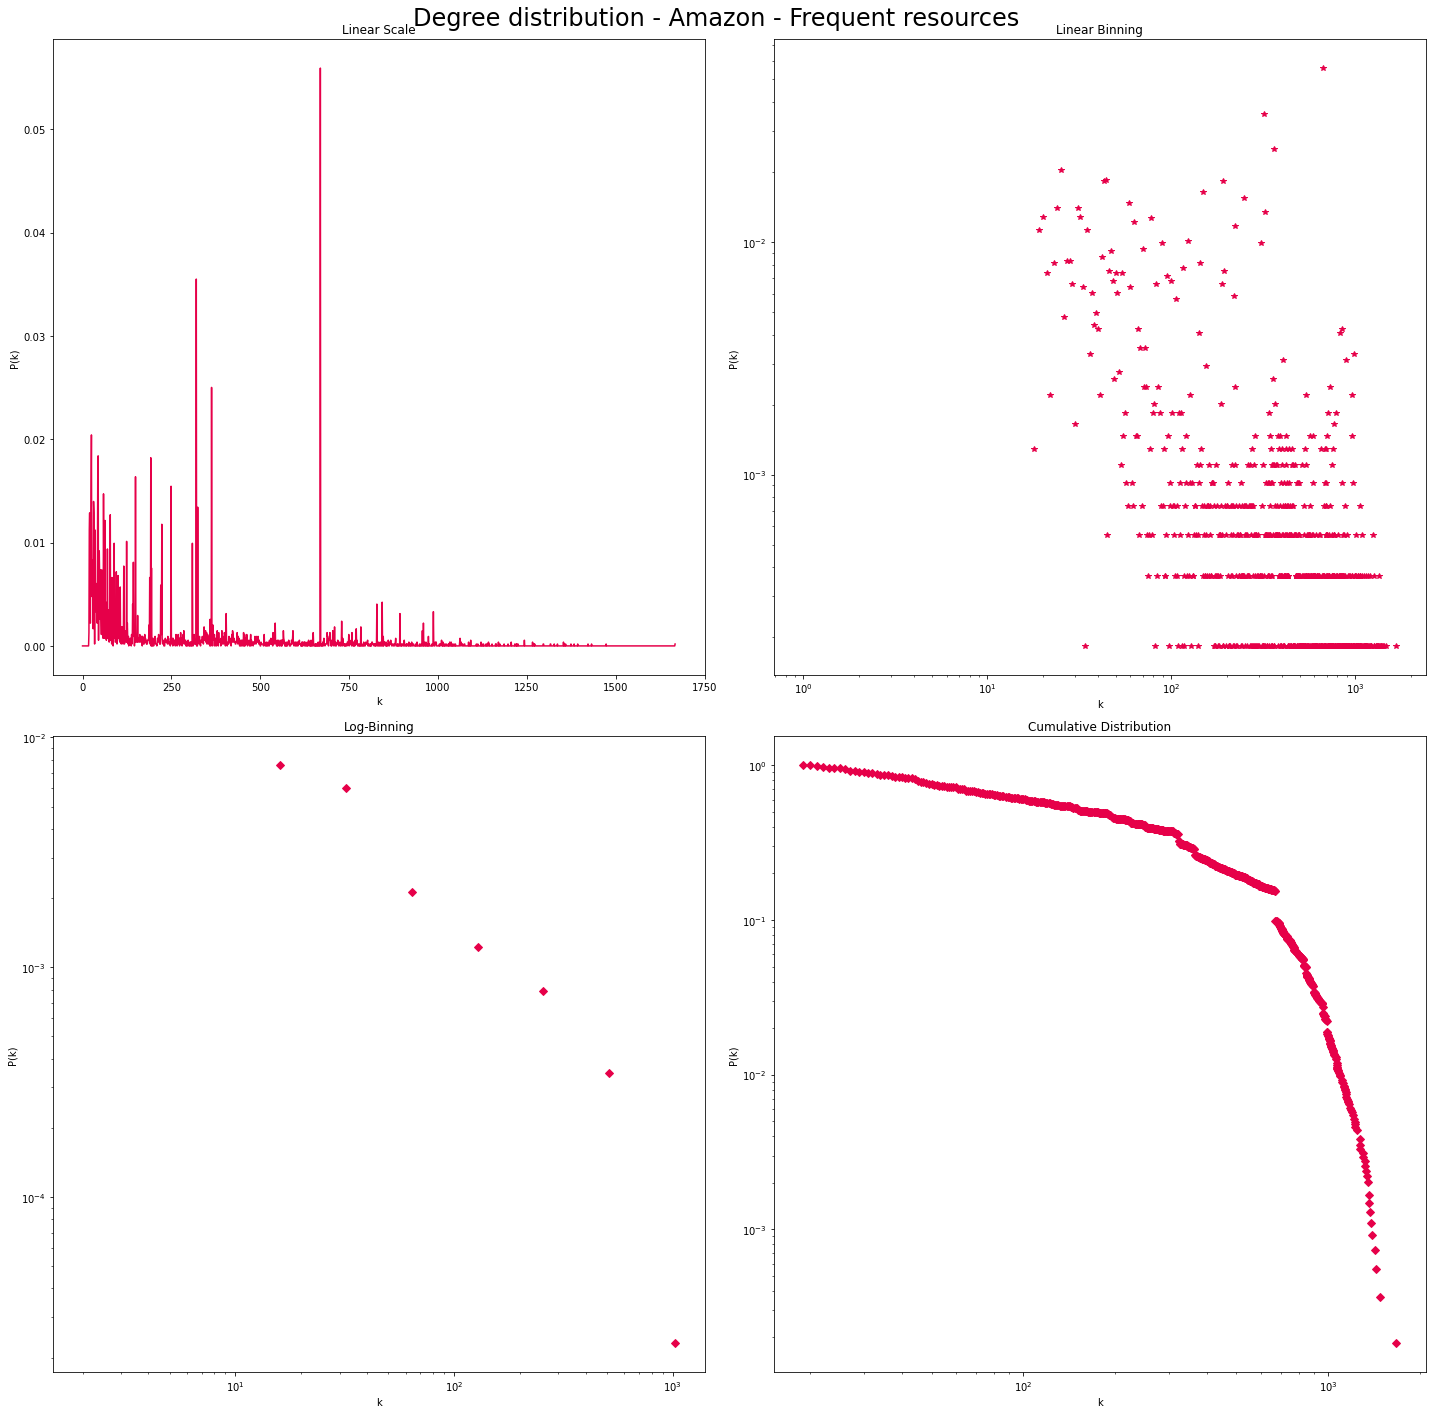

In [6]:
max_degree = max(user_network.degree())
print(max_degree)

# Crear una lista donde se almacena
degree_list = np.zeros(max_degree, dtype=int)

for node in user_network.vs():    
    degree_list[node.degree()-1] = (degree_list[node.degree()-1] + 1)

degree_list = degree_list / user_network.vcount()

plt.clf()
fig, axs = plt.subplots(2, 2, figsize=(20,20))

# LINEAR SCALE
axs[0, 0].set_title('Linear Scale')
axs[0, 0].plot(degree_list, color='#e60049')
axs[0, 0].set(ylabel='P(k)', xlabel='k')

# LINEAR BINNING
axs[0, 1].set_title('Linear Binning')
axs[0, 1].plot(range(max_degree), degree_list, color="#e60049", marker='*', ls='None')
axs[0, 1].loglog()
axs[0, 1].set(ylabel='P(k)', xlabel='k')

# LOG-BINNING
axs[1, 0].set_title('Log-Binning')
n_log_bin = ceil(log2(max(user_network.degree())))
x_values, y_values = calculate_log_binning(degree_list, n_log_bin)
axs[1, 0].plot(x_values, y_values, color='#e60049', marker="D", ls='None')
axs[1, 0].loglog()
axs[1, 0].set(ylabel='P(k)', xlabel='k')

# COMULATIVE
axs[1, 1].set_title("Cumulative Distribution")
degree_sequence = sorted([d for d in user_network.degree()], reverse=True)  # degree sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(np.array(cnt)/user_network.vcount())
axs[1, 1].loglog(deg, cs, color='#e60049', marker="D", ls='None')
axs[1, 1].set(ylabel='P(k)', xlabel='k')

fig.suptitle("Degree distribution - Amazon - Frequent resources", fontsize=24)
fig.tight_layout()
plt.show()

### Weighted distribution

1000


<Figure size 432x288 with 0 Axes>

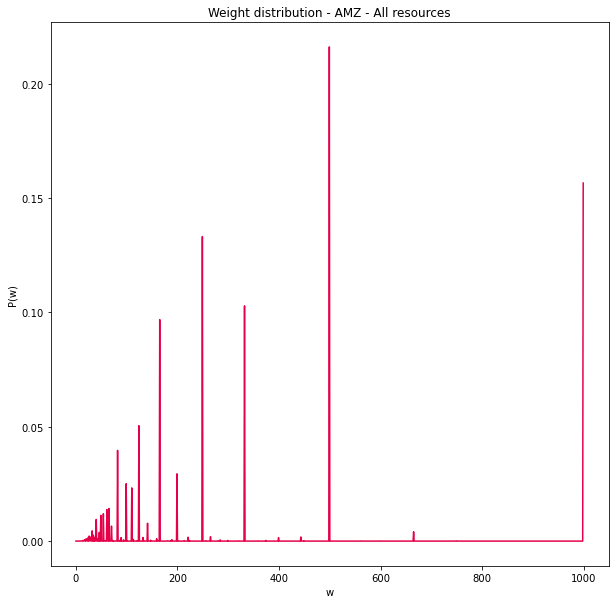

In [13]:
arreglo_test = (np.array(user_network.es['weight'])*1000).astype(int)
max_peso = max(arreglo_test)
print(max_peso)

# Crear una lista donde se almacena
arreglo_test_ = np.zeros(max_peso, dtype=int)

for node in arreglo_test:
    arreglo_test_[node-1] = (arreglo_test_[node-1] + 1)

arreglo_test_ = arreglo_test_ / user_network.ecount()

plt.clf()
plt.figure(figsize=(10,10))
plt.plot(arreglo_test_, color="#e60049")
plt.title("Weight distribution - AMZ - All resources")
plt.xlabel("w")
plt.ylabel("P(w)")
#plt.loglog()
plt.show()

In [21]:
user_network_test = user_network.copy()
user_network_test.es.select(weight_lt=0.4).delete()

In [ ]:
density = user_network_test.density()
print("Density:", density)

avg_degree = sum(user_network_test.degree()) / user_network_test.vcount()
print("Avg. degree", avg_degree)

components = user_network_test.components()
print("Connected Components:", len(components))

### Calculete changes of densities

In [32]:
densitites_list = [user_network.density()] # Store all densities values
thresholds_list = np.linspace(0, 1, num=11)[1:-1] # nine values

for thrs in thresholds_list:
    current_user_net = user_network.copy() # Create a copy of user network
    
    # Remove edges less than current threshold
    current_user_net.es.select(weight_lt=thrs).delete()
    
    current_density = current_user_net.density() # Compute density
    
    # Store current density in the density list
    densitites_list.append(current_density)

# Show densities
print(densitites_list)

[0.022874443231497874, 0.009990839019907624, 0.005340227964554199, 0.003177833267323172, 0.0022572399424410318, 0.002229144219662889, 0.0008576589058590997, 0.0008370455176734518, 0.0008365427521079481, 0.0008364540287728594]


<Figure size 432x288 with 0 Axes>

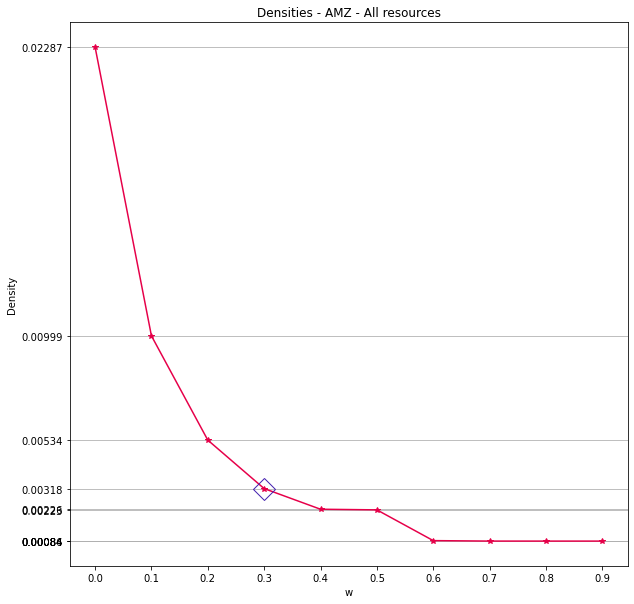

In [61]:
plt.clf()
plt.figure(figsize=(10,10))
plt.plot([0]+list(thresholds_list), densitites_list, color="#e60049", marker='*')
plt.title("Densities - AMZ - All resources")
plt.xlabel("w")
plt.xticks([0]+list(thresholds_list))
plt.ylabel("Density")
plt.yticks(densitites_list)
plt.grid(axis='y')
plt.plot(0.3, densitites_list[3], marker="D", markersize=15, fillstyle='none', color="#4421af")
#plt.loglog()
plt.show()

### Components Analysis

In [42]:
# Shows the size counter of the components
dict_compoenents = dict(Counter(components.sizes()))
print(dict_compoenents)

{8068: 1, 2: 46, 3: 14, 4: 4, 6: 1}


dict_values([1, 46, 14, 4, 1])

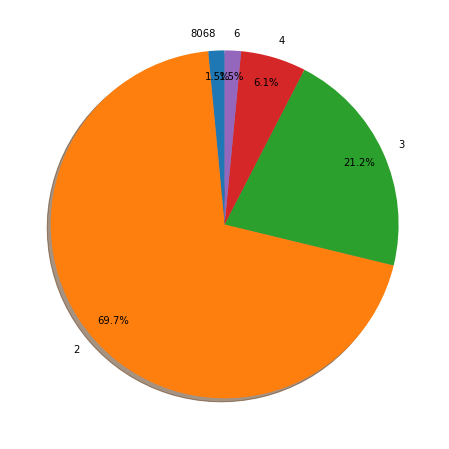

In [56]:
fig, ax = plt.subplots(figsize=(8,))
ax.pie(dict_compoenents.values(), labels=dict_compoenents.keys(), 
       autopct='%1.1f%%', startangle=90, shadow=True, pctdistance=.85)
plt.show()

In [117]:
### Compute the % of nodes in the huge component

# In this case, we have huge component in index=0
huge_component = components.subgraph(0)
print("HugeComp Nodes:", huge_component.vcount())
print("HugeComp Edges:", huge_component.ecount())

# We recall how many user there
n_users_bip = user_network.vcount()
print("|Nodes| =", n_users_bip)

# % of nodes in the huge component
pct_users_huge = huge_component.vcount() / n_users_bip
print("Pct of nodes: {:.2f}%".format(pct_users_huge*100))

# % of links in the huge component 
n_res_bip = user_network.ecount()
print("|Edges| =", n_res_bip)
pct_res_huge = huge_component.ecount() / n_res_bip
print("Pct of edges: {:.2f}%".format(pct_res_huge*100))

HugeComp Nodes: 8068
HugeComp Edges: 773338
|Nodes| = 8224
Pct of nodes: 98.10%
|Edges| = 773453
Pct of edges: 99.99%


In [166]:
### Compute the resources in the components.

counter_res = [] # Save all resources 
counter_res_huge = [] # Save resources in huge component

for compnt in components.subgraphs(): # Omit the huge component
    # Get node users
    users_comp = list(compnt.vs())    
    
    rsrc_in_components = [] # Store "name" attribute of resources

    # Loop over user nodes
    for i_node in users_comp:
        # Search the node in the bipartite network by its name
        i_query = bip_network.vs.find(name=i_node["name"])

        # Get the resources (neighbors) of i_node
        neighs_inodes = bip_network.neighbors(i_query)
        
        # loop over the resources
        for i_rsrc in neighs_inodes:
            # Adding to list
            rsrc_in_components.append(bip_network.vs(i_rsrc)[0]["name"])

    # Remove duplicate values
    rsrc_in_components = list(set(rsrc_in_components))
    
    if len(users_comp) == 8068: # The huge component
        counter_res_huge += rsrc_in_components
    else:
        counter_res += rsrc_in_components # Global resources in small components

# Remove duplicate values
counter_res = list(set(counter_res))
print(len(counter_res), counter_res)

counter_res_huge = list(set(counter_res_huge))
print(len(counter_res_huge), counter_res_huge)

117 [74241, 73741, 36885, 78882, 75815, 89134, 35374, 80947, 73783, 84024, 74297, 79936, 6723, 77390, 34895, 31834, 78429, 78435, 78436, 16997, 36971, 99949, 74874, 100475, 36476, 77946, 74367, 77951, 74369, 27786, 74896, 32401, 74899, 30868, 80021, 79000, 25753, 43165, 27309, 31921, 31922, 74930, 45236, 45237, 73907, 35000, 109753, 71866, 16570, 39612, 31936, 36036, 6855, 716, 79566, 74447, 28370, 42709, 19678, 6878, 74982, 78570, 37115, 27901, 43265, 20744, 39695, 75032, 79640, 78108, 34076, 78111, 40753, 25407, 27970, 26436, 15697, 43860, 56665, 33115, 78178, 37221, 37222, 43879, 26985, 30573, 74610, 73075, 28532, 36724, 74614, 78713, 35716, 28550, 35722, 43915, 45451, 42382, 42383, 37781, 28568, 36772, 75685, 23461, 77225, 44975, 41399, 42945, 70088, 42967, 41433, 32223, 35819, 45044, 74743, 34300, 105470]
5944 [0, 38, 98430, 98431, 98437, 138, 153, 98494, 98500, 199, 203, 216, 32985, 32986, 32987, 32997, 33001, 33002, 233, 237, 98547, 33012, 98552, 256, 33031, 33032, 33033, 33035,

In [168]:
### Number of resources in each component
# Total of resources
total_counter_res = counter_res + counter_res_huge

# Remove duplicate values
total_counter_res = list(set(total_counter_res))

# % of resources in small components of all
pct_res = (len(counter_res) / len(total_counter_res))*100
print("Pct of resources (SMALL): {:.2f}% - ({} / {})".format(pct_res,
                                                             len(counter_res),
                                                             len(total_counter_res)))

# % of resources in small components of all
pct_res = (len(counter_res_huge) / len(total_counter_res))*100
print("Pct of resources (HUGE): {:.2f}% - ({} / {})".format(pct_res, 
                                                            len(counter_res_huge),
                                                            len(total_counter_res)))

Pct of resources (SMALL): 1.93% - (117 / 6061)
Pct of resources (HUGE): 98.07% - (5944 / 6061)


In [171]:
### Importance of resources in each component

dict_freq_res = {} # Save counter access

for i_res in counter_res: # Small components
    # Number of accesss requests in Dataframe
    dict_freq_res[i_res] = len(df_train_k_pos[df_train_k_pos.RESOURCE==i_res])

print("MAX access in a resource (SMALL):", max(dict_freq_res.values()))

for i_res in counter_res_huge: # Small components
    # Number of accesss requests in Dataframe
    dict_freq_res[i_res] = len(df_train_k_pos[df_train_k_pos.RESOURCE==i_res])

print("MAX access in a resource (HUGE):", max(dict_freq_res.values()))

MAX access in a resource (SMALL): 5
MAX access in a resource (HUGE): 671


In [181]:
### Analysis all networks vs huge compoenent

density = user_network.density()
print("Density (ALL):", "{:.4f}".format(density))
density = huge_component.density()
print("Density (HUGE):", "{:.4f}".format(density))

avg_degree = sum(user_network.degree()) / user_network.vcount()
print("Avg. degree (ALL)", "{:.4f}".format(avg_degree))
avg_degree = sum(huge_component.degree()) / huge_component.vcount()
print("Avg. degree (HUGE)", "{:.4f}".format(avg_degree))

components = user_network.components()
print("Connected Components (ALL):", len(components))
components = huge_component.components()
print("Connected Components (HUGE):", len(components))

cc = user_network.transitivity_avglocal_undirected()
print("Clustering Coefficient (ALL):", "{:.4f}".format(cc))
cc = huge_component.transitivity_avglocal_undirected()
print("Clustering Coefficient: (HUGE)", "{:.4f}".format(cc))

L = user_network.average_path_length()
print("Average Path Length (ALL):", "{:.4f}".format(L))
L = huge_component.average_path_length()
print("Average Path Length (HUGE):", "{:.4f}".format(L))

Density (ALL): 0.0229
Density (HUGE): 0.0238
Avg. degree (ALL) 188.0965
Avg. degree (HUGE) 191.7050
Connected Components (ALL): 66
Connected Components (HUGE): 1
Clustering Coefficient (ALL): 0.7931
Clustering Coefficient: (HUGE) 0.7924
Average Path Length (ALL): 2.8750
Average Path Length (HUGE): 2.8750


### Community Analysis

In [6]:
### Community detection algorithm

# Louvain Algorithm
partition = user_network.community_multilevel(weights=user_network.es()["weight"])
print("Modularity: %.4f" % partition.modularity) # Modualarity value

# Add cluster attribute to nodes
user_network.vs["commty"] = partition.membership

print(user_network.summary())
print(partition.summary())

Modularity: 0.6515
IGRAPH UNW- 5436 743311 -- 
+ attr: commty (v), name (v), rsrcs (v), weight (e)
Clustering with 5436 elements and 16 clusters


In [7]:
dict_commts = sub_community_detection(user_network, partition, 0.5)
dict_commts

{'0': [<igraph.Graph at 0x224d2513408>,
  [74883,
   28294,
   32270,
   17308,
   41758,
   40867,
   39331,
   34861,
   15022,
   35376,
   23096,
   3130,
   6977,
   4675,
   75078,
   25287,
   27082,
   39883,
   27356,
   39262,
   42093,
   23921,
   18418,
   27124,
   1020,
   7678]],
 '1': [<igraph.Graph at 0x224d25134f8>,
  [74754,
   28294,
   34950,
   3853,
   41758,
   39331,
   40867,
   39333,
   34861,
   15022,
   42031,
   35376,
   43952,
   44722,
   6977,
   4675,
   75078,
   25287,
   39883,
   27356,
   39262,
   41314,
   34026,
   42093,
   18418,
   74995,
   79092,
   28149,
   27124]],
 '2': [<igraph.Graph at 0x224d25135e8>,
  [75078, 20364, 42031, 35376, 41758, 28149, 73815, 39262]],
 '3': [<igraph.Graph at 0x224d25136d8>,
  [74754,
   25993,
   20364,
   3853,
   32270,
   22682,
   17308,
   37793,
   20897,
   40867,
   39331,
   39333,
   34861,
   15022,
   35376,
   73144,
   3130,
   75834,
   16443,
   16191,
   6977,
   4675,
   79299,
   7507

In [8]:
# Se obtienen las comunidades y sub-comunidades
g = user_network

density_threshold = 0.5

n_coms = len(set(g.vs["cluster"]))
count_n_coms = 0 # Contador de número de comunidades detectadas
# Diccionario con las comunidades. Id de la comunidad como key y una lista 
# como value {01: [subgrafo, recursos_list]}
dict_total_coms = {} 
id_comunidad = 0

for idx_comm in range(n_coms): # Recorrer cada comunidad en la red
    subgraph_nodes = g.vs.select(cluster=idx_comm) # Sacamos los nodos con el cluster
    comm_subgraph = subgraph_nodes.subgraph() # Objeto de subgrafo

    # Verificar si la densidad es baja: Si es baja se puede clasificar
    if comm_subgraph.density() < density_threshold:

        # Se realiza nuevamente una partición
        new_partition = comm_subgraph.community_multilevel(
            weights =comm_subgraph.es["weight"] )        

        for sub_com in new_partition.subgraphs(): # Se recorre cada nueva sub comunidad
            # Usuarios en la comunidad
            user_set_comm = sub_com.vs()["name"]   
            # Recursos en la comunidad
            n_res = num_recursos(user_set_comm, bip_network)            
            dict_total_coms[str(count_n_coms)] = [sub_com, n_res]
            add_id_comm_to_nodes(g, user_set_comm, id_comunidad)
            id_comunidad += 1
            count_n_coms += 1
    else:
        user_set_comm = comm_subgraph.vs()["name"]   
        # Recursos en la comunidad
        n_res = num_recursos(user_set_comm, bip_network)            
        dict_total_coms[str(count_n_coms)] = [comm_subgraph, n_res]
        add_id_comm_to_nodes(g, user_set_comm, id_comunidad)
        id_comunidad += 1
        count_n_coms += 1

print("# de Comunidades: ", len(dict_total_coms))

# de Comunidades:  91


In [14]:
### Classify communities
def num_recursos(user_sets, grafo_bip):
    all_recursos = set()
    user_sets = [int(float(i)) for i in user_sets]
    for user in user_sets:
        user_node = grafo_bip.vs.find(name=int(float(user)))
        vecinos_recurso = user_node.neighbors()
        vecinos_recurso = [nodo["name"] for nodo in vecinos_recurso]
        vecinos_recurso = set(vecinos_recurso)    
        all_recursos = all_recursos.union(vecinos_recurso)
    return list(all_recursos)            

def numero_registros2(sub_com, dataf):
    """Retorna los registros en una comunidad."""
    dict_resc = {}
    for node in sub_com.vs():
        recursos = list(dataf[dataf.USRID == float(node["label"])]["RESID"])
        for i in recursos:
            if i in dict_resc.keys():
                dict_resc[i] += 1
            else:
                dict_resc[i] = 1
    
    # Remove low values
    dict_temp = {}
    for item in dict_resc.items():
        if item[1] > 2:
            dict_temp[item[0]] = item[1]
    dict_temp = dict(sorted(dict_temp.items(), key=lambda item: item[1], reverse=True))

    if len(dict_temp) < 1:
        return  len(list(dict_temp.keys()))
    return len(list(dict_temp.keys()))

def numero_registros3(sub_com, dataf):
    """Retorna los registros en una comunidad."""
    dict_resc = {}
    for node in sub_com.vs():
        recursos = list(dataf[dataf.USRID == float(node["label"])]["RESID"])
        for i in recursos:
            if i in dict_resc.keys():
                dict_resc[i] += 1
            else:
                dict_resc[i] = 1
    
    # Remove low values
    dict_temp = {}
    for item in dict_resc.items():
        if item[1] > 2:
            dict_temp[item[0]] = item[1]
    dict_temp = dict(sorted(dict_temp.items(), key=lambda item: item[1], reverse=True))

    if len(dict_temp) < 1:
        return  dict_temp
    # return len(list(dict_temp.keys()))
    return dict_temp


def numero_registros4(sub_com, dataf):
    """Retorna los registros en una comunidad."""
    dict_resc = {}
    for node in sub_com.vs():
        recursos = list(dataf[dataf.USRID == int(node["label"])]["RESID"])
        for i in recursos:
            if i in dict_resc.keys():
                dict_resc[i] += 1
            else:
                dict_resc[i] = 1
    
    # Remove low values
    dict_temp = {}
    for item in dict_resc.items():
        if item[1] > 2:
            dict_temp[item[0]] = item[1]
    dict_temp = dict(sorted(dict_temp.items(), key=lambda item: item[1], reverse=True))

    if len(dict_temp) < 1:
        return  dict_temp
    # return len(list(dict_temp.keys()))
    return dict_temp

def get_users_from_resource_comms(resource_id, community, data):
    """Retorna los usuarios de la comunidad que acceden al conjunto de recursos"""
    users_to_ret = []
    for res in resource_id:
        all_user_in_community = community.vs()["label"] # Extraer usuarios de comunidad
        ## all_user_in_community = [int(item) for item in all_user_in_community] # Convertimos a int
        all_user_in_community = set(all_user_in_community) # Covnertimos a conjunto
        solicitudes_en_data = data[data["RESID"]==res]["USRID"].to_list() # Todos los usuarios que acceden al recurso
        solicitudes_en_data = [str(item)+".0" for item in solicitudes_en_data]
        solicitudes_en_data = set(solicitudes_en_data)
        # print(all_user_in_community)
        # print(solicitudes_en_data)
        users_to_ret = users_to_ret + list(all_user_in_community.intersection(solicitudes_en_data)) # Intersección
    users_to_ret = list(set(users_to_ret))
    return users_to_ret

def remove_equal_rules(rules):
    """ Remove equal rules X -> Y == Y -> X"""
    to_remove = []
    lrules = len(rules)
    for i in range(lrules):
        for j in range(i+1,lrules):
            if rules[i][0] == rules[j][1] and rules[i][1] == rules[j][0]:        
                to_remove.append(rules[i])

    #print(to_remove)
    return to_remove

def remove_equal_rules2(rules):
    """ Remove equal rules X -> Y == Y -> X"""
    to_remove = []
    for rule in rules:
        descri = []
        for ele in rule[0]:
            descri.append(ele)
        for ele in rule[1]:
            descri.append(ele)
        descri.sort()
        if descri in to_remove:
            continue
        else:            
            to_remove.append(descri)

    # Quedarse con la de mayor tamaño
    max_id = 0
    to_ret = None
    for i in to_remove:        
        if len(i) > max_id:            
            max_id = len(i)
            to_ret = i

    return [to_ret]

# Function to check if a value appear in column
def get_attr_name(value, df_):
    """ Return name of the column of the value."""
    cols = df_.columns  
    if value == 10:
            # Buscar el atributo maximo
        max_val = 0
        attr_  = None
        for i in cols:        
            t = len(df_[df_[i]==10])            
            if t > max_val:
                max_val = t
                attr_ = i
        return attr_
    else:
        for i in range(len(cols)):        
            if len(df_[df_[cols[i]]==value]) > 0:
                return df_.columns[i]

def get_attr_val_in_users(users_id, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""
    user_convert = [float(n) for n in users_id] # Convertimos a float
    attr_user_ = data[data["USRID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[user_attr+["USRID"]].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[user_attr+["USRID"]]
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # print(rules)
    rules = remove_equal_rules2(rules)
    #print("XXX",rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def get_attr_val_in_users_2(users_id, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""
    user_convert = [float(n) for n in users_id] # Convertimos a float
    attr_user_ = data[data["USRID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[user_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[user_attr+["USRID"]]
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
        if init_Sup < 0:
            return attr_user__
    # print(rules)
    rules = remove_equal_rules2(rules)
    #print("XXX",rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def get_attr_val_in_res(res_ids, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""    
    user_convert = [float(n) for n in res_ids] # Convertimos a float
    attr_user_ = data[data["RESID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[rsrc_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[rsrc_attr+["RESID"]]
    #print(attr_user_)
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # _, rules = apriori(attr_user__, minSup=0.6, minConf=0.9) # Apply apriori
    rules = remove_equal_rules2(rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def get_attr_val_in_res_2(res_ids, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""    
    user_convert = [float(n) for n in res_ids] # Convertimos a float
    attr_user_ = data[data["RESID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    attr_user__ = attr_user_[rsrc_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[rsrc_attr+["RESID"]]
    #print(attr_user_)
    # print(attr_user_)
    init_Sup = 0.6
    init_Conf = 0.9
    rules = []
    while len(rules) == 0:
        # print("Sup", init_Sup, "  Conf", init_Conf)
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
        if init_Sup < 0:
            return attr_user__
    # _, rules = apriori(attr_user__, minSup=0.6, minConf=0.9) # Apply apriori
    rules = remove_equal_rules2(rules)
    #for r in rules:
    #    print(r)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi


def podado_recursos(recursos, subgrafo, umbral):
    """Realiza el podado de los recursos que casi no acceden"""
    n_usuarios = subgrafo.vcount()
    to_ret = {}    
    for i in recursos:
        us_temp = recursos[i]
        if (us_temp / n_usuarios) > umbral:
            to_ret[i] = us_temp
    return to_ret

def recurso_significativo(recursos, subgrafo, umbral):
    """Retorna el recurso significativo. 'None' si no hay."""
    n_usuarios = subgrafo.vcount()
    to_ret = {}    
    for i in recursos:
        us_temp = recursos[i]
        if (us_temp / n_usuarios) >= umbral:
            return to_ret[i]
    return None

def extraer_recursos_similares(recursos, data_, umbral):
    """Retorna registros similares como nuevos registros"""

    for atr in rsrc_attr: # Se reccorre los atributos
        for r1 in recursos: # Se recorre los recursos
            for atr2 in rsrc_attr:
                if atr != atr2: # Se cambian los recursos
                    print()


def get_apriori_final(usuarios, recursos, data):
    """Retorna los atributo valor en comun en un conjunto de usuarios."""
    user_convert = [float(n) for n in usuarios] # Convertimos a float
    attr_user_ = data[data["USRID"].isin(user_convert)].drop_duplicates() # Seleccionamos usuarios
    res_convert = [float(n) for n in recursos] # Convertimos a float
    attr_user_ = attr_user_[attr_user_["RESID"].isin(res_convert)].drop_duplicates() # Seleccionamos recursos
    attr_user__ = attr_user_[user_attr+rsrc_attr].values.tolist() # Seleccionamos attributos de los usuarios
    attr_user_ = attr_user_[user_attr+rsrc_attr]
    # print(attr_user_)
    init_Sup = 0.5
    init_Conf = 0.8
    rules = []
    while len(rules) == 0:
        _, rules = apriori(attr_user__, minSup=init_Sup, minConf=init_Conf) # Apply apriori
        init_Sup -= 0.1
        init_Conf -= 0.1
    # print(rules)
    rules = remove_equal_rules2(rules)
    
    reglas_karimi = []
    for r in rules:      
        for t in r:                                    
            col = get_attr_name(t, attr_user_)                                                             
            reglas_karimi.append([col, t])

    return reglas_karimi

def agregar_diccionario(diccionario, recurso, tupla_datos):
    if recurso in diccionario:
        diccionario[recurso].append(tupla_datos)
    else:
        diccionario[recurso] = [tupla_datos]

def agregar_usuario_com(diccio, com_id, usuario):
    if com_id in diccio:
        if not usuario in diccio[com_id]:
            diccio[com_id].append(usuario)
    else:
        
        diccio[com_id] = [usuario]


In [8]:
# Obtener el máximo valor de recursos en el total de comunidades
n_res_in_comms = [len(i[1]) for i in dict_commts.values()]
max_n_res = max(n_res_in_comms)
print("Comunidad con # mayor recursos", max_n_res)

# Umbrales para la clasificación de comunidades
big_threshold = int(0.50 * max_n_res)
med_threshold = int(0.25 * max_n_res)
print("Big Threshold: ", big_threshold, " \t\t Med Threshold", med_threshold)

Comunidad con # mayor recursos 103
Big Threshold:  51  		 Med Threshold 25


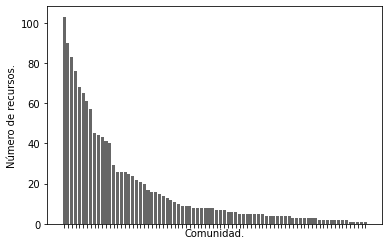

In [9]:
plt.bar(dict_commts.keys(), sorted(n_res_in_comms, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('n_recursos_por_comunidad_amz.pdf')

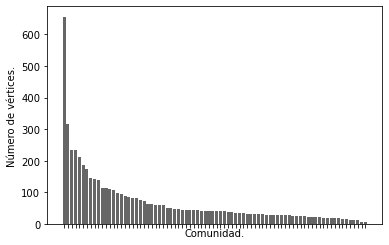

In [10]:
lista_tamano_coms = []
for i in dict_commts:
    lista_tamano_coms.append(dict_commts[i][0].vcount())
    #print(dict_total_coms[i][0].vcount())
len(lista_tamano_coms)

# plt.figure(figsize=(20,15))
plt.bar(dict_commts.keys(), sorted(lista_tamano_coms, reverse=True), color='0.40')
plt.ylabel('Número de vértices.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('n_vertices_por_comunidad_amz.pdf')

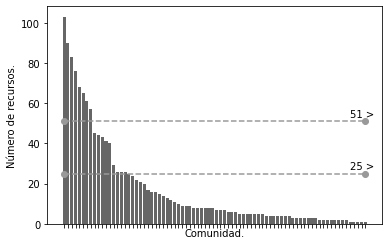

In [11]:
# plt.figure(figsize=(20,15))
plt.bar(dict_commts.keys(), sorted(n_res_in_comms, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
x, y = [0, len(n_res_in_comms)-1] , [big_threshold, big_threshold]
plt.plot(x, y, marker = 'o', linestyle='--', color="0.6")
plt.text(len(n_res_in_comms)-5, big_threshold+6, '{} >'.format(big_threshold) , ha='left', va= 'top')
x, y = [0, len(n_res_in_comms)-1] , [med_threshold, med_threshold]
plt.plot(x, y, marker = 'o', linestyle='--', color="0.6")
plt.text(len(n_res_in_comms)-5, med_threshold+6, '{} >'.format(med_threshold) , ha='left', va= 'top')
plt.tick_params(labelbottom=False)
#plt.savefig('n_recursos_por_comunidad_amz-corte.pdf')

In [24]:
def agregar_tipo_com(grafo, set_users_, tipo):
    for user_ in set_users_:
        vertice = grafo.vs.find(name=user_)
        vertice["tipoCom"] = tipo

In [13]:
s_commts, m_commts, c_commts = add_type_commts(user_network, dict_commts,
                                               big_threshold, med_threshold)

# Comunidades: 240 == 80
Big Comms: 80
Med Comms: 80
Sma Comms: 80


In [25]:
big_comms = [] # Almacenar las comunidades grandes
med_comms = [] # Almacenar las comunidades medianas
sma_comms = [] # Almacenar las comunidades pequeñas
user_network.vs["tipoCom"] = -1


for idx_com, com in enumerate(dict_commts.values()):
    if len(com[1]) > big_threshold: # Es comunidad grande
        big_comms.append([idx_com]+com)
        nodos_ = com[0].vs["name"]
        agregar_tipo_com(user_network, nodos_, 0)
    elif len(com[1]) > med_threshold: # Es comunidad mediana
        med_comms.append([idx_com]+com)
        nodos_ = com[0].vs["name"]
        agregar_tipo_com(user_network, nodos_, 1)
    else:
        sma_comms.append([idx_com]+com)
        nodos_ = com[0].vs["name"]
        agregar_tipo_com(user_network, nodos_, 2)

print("# Comunidades:",len(big_comms)+len(med_comms)+len(sma_comms), "==", len(dict_commts))
print("Big Comms:", len(big_comms))
print("Med Comms:", len(med_comms))
print("Sma Comms:", len(sma_comms))

# Comunidades: 80 == 80
Big Comms: 8
Med Comms: 9
Sma Comms: 63


## Resources in commts

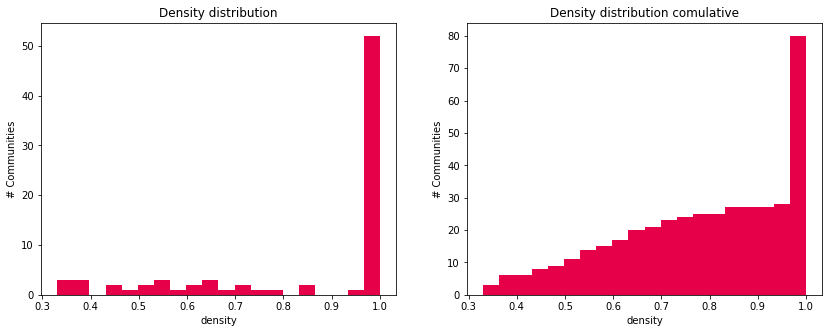

In [26]:
### Density distribution of each community

density_distribution = [] # Store all densities

for comty in sma_comms+med_comms+big_comms: # Loop over all type communities    
    temp_density = comty[1].density() # Graph object [1]
    density_distribution.append(temp_density)

fig, axs = plt.subplots(1, 2, figsize=(14,5))

counts, bins = np.histogram(density_distribution, 20)

# Density distribution
axs[0].set_title('Density distribution')
axs[0].hist(bins[:-1], bins, weights=counts, color="#e60049")
axs[0].set(ylabel='# Communities', xlabel='density')

axs[1].set_title('Density distribution comulative')
axs[1].hist(bins[:-1], bins, weights=counts, color="#e60049", cumulative=True,
            histtype="bar")
axs[1].set(ylabel='# Communities', xlabel='density')

plt.show()


In [27]:
### Resource accessed distribution by communities
# Recorresr todos los recursos y ver los usuarios que acceden al él. Detectar
# de cual tipo de comunidad atrae más usuarios.

all_types_coms = sma_comms + med_comms + big_comms # All types of communitites

 # Store the number of users in each type of community
dict_user_coms = {} # Example -> {id_res: {sma: 40, med: 12, big: 4}, ...}

for rsrc in bip_network.vs.select(typen=1):
    # Get all users "name" which accessed to the rsrc (resource)
    users_name_accessed = [i["name"] for i in rsrc.neighbors()]

    # Counters
    counter_small = 0
    counter_med = 0
    counter_big = 0
    rsr_impor_sma = rsr_impor_med = rsr_impor_big = 0    
    counter_coms = 0
    counter_coms_type_sma = counter_coms_type_med = counter_coms_type_big = 0
    
    # Get all user in small communities
    for comty in sma_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_small += len(intersec_users)
            rsr_impor_sma += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_sma = rsr_impor_sma / counter_coms
        counter_coms_type_sma = counter_coms / len(sma_comms)
    else:
        rsr_impor_sma = 0
        counter_coms_type_sma = 0
    counter_coms = 0

    # Get all user in small communities
    for comty in med_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_med += len(intersec_users)
            rsr_impor_med += len(intersec_users) / len(users_in_com)
            counter_coms += 1
        
    if counter_coms > 0:
        rsr_impor_med = rsr_impor_med / counter_coms
        counter_coms_type_med = counter_coms / len(med_comms)
    else:
        rsr_impor_med = 0
        counter_coms_type_med = 0
    counter_coms = 0

    for comty in big_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_big += len(intersec_users)
            rsr_impor_big += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_big = rsr_impor_big / counter_coms
        counter_coms_type_big = counter_coms / len(big_comms)
    else:
        rsr_impor_big = 0
        counter_coms_type_big = 0
    counter_coms = 0

    
    total_accessed = counter_big + counter_small + counter_med
    total_counter_coms = counter_coms_type_sma + counter_coms_type_med + counter_coms_type_big
    total_rsr_impor = rsr_impor_sma + rsr_impor_med + rsr_impor_big
    # Add all counters
    dict_user_coms[rsrc["name"]] = {"sma": counter_small/total_accessed,
                                     "med": counter_med/total_accessed,
                                     "big":counter_big/total_accessed}
    
#dict_user_coms

In [28]:
a = pd.DataFrame(dict_user_coms)
a = a.T
a["name"] = range(150)
a = a.sort_values("sma", ascending=False)
a.rename(columns = {'sma':'Concentradas', "med": "Medianas", "big":"Dispersas"}, inplace = True)
a

,Concentradas,Medianas,Dispersas,name
43876,1.0,0.000000,0.000000,121
26437,1.0,0.000000,0.000000,148
6725,1.0,0.000000,0.000000,98
37734,1.0,0.000000,0.000000,22
20293,1.0,0.000000,0.000000,68
...,...,...,...,...
1020,0.0,0.747423,0.252577,25
79092,0.0,0.010959,0.989041,5
40069,0.0,0.047619,0.952381,123
3853,0.0,0.018405,0.981595,10


<Figure size 1440x2160 with 0 Axes>

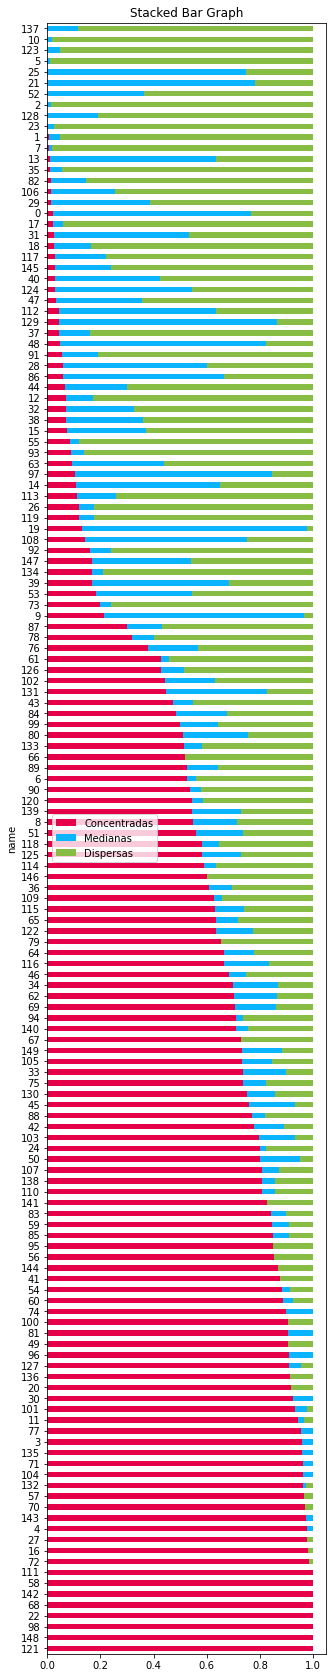

In [29]:
 #plot a Stacked Bar Graph
colors = ['#e60049', '#0bb4ff', '#87bc45']
plt.figure(figsize=(20,30))
a.plot(
    x = "name",
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True, figsize=(5,30), color=colors)
plt.show()

In [167]:
### Resource accessed distribution by communities
# Recorresr todos los recursos y ver los usuarios que acceden al él. Detectar
# de cual tipo de comunidad atrae más usuarios.

all_types_coms = sma_comms + med_comms + big_comms # All types of communitites

 # Store the number of users in each type of community
dict_user_coms = {} # Example -> {id_res: {sma: 40, med: 12, big: 4}, ...}

for rsrc in bip_network.vs.select(typen=1):
    # Get all users "name" which accessed to the rsrc (resource)
    users_name_accessed = [i["name"] for i in rsrc.neighbors()]

    # Counters
    counter_small = 0
    counter_med = 0
    counter_big = 0
    counter_coms = 0
    counter_coms_type_sma = counter_coms_type_med = counter_coms_type_big = 0
    
    # Get all user in small communities
    for comty in sma_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_small += len(intersec_users)
            rsr_impor_sma += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        counter_coms_type_sma = counter_coms / len(sma_comms)
    else:
        counter_coms_type_sma = 0
    counter_coms = 0

    # Get all user in small communities
    for comty in med_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_med += len(intersec_users)
            rsr_impor_med += len(intersec_users) / len(users_in_com)
            counter_coms += 1
        
    if counter_coms > 0:
        counter_coms_type_med = counter_coms / len(med_comms)
    else:
        counter_coms_type_med = 0
    counter_coms = 0

    for comty in big_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_big += len(intersec_users)
            rsr_impor_big += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        counter_coms_type_big = counter_coms / len(big_comms)
    else:
        counter_coms_type_big = 0
    counter_coms = 0

    total_accessed = counter_big + counter_small + counter_med


    # Add all counters
    dict_user_coms[rsrc["name"]] = {"impComSma": counter_coms_type_sma,
                                    "impSmaRes": 1-counter_coms_type_sma,
                                     "impComMed": counter_coms_type_med,
                                     "impMedRes": 1-counter_coms_type_med,
                                     "impComBig": counter_coms_type_big,
                                     "impBigRes": 1-counter_coms_type_big,
                                     "sma": counter_small/total_accessed}
    
#dict_user_coms

In [170]:
a = pd.DataFrame(dict_user_coms)
a = a.T
a["name"] = range(150)
a = a.sort_values("sma", ascending=False)
a = a.drop("sma", axis=1)
a.rename(columns = {'impComSma':'Concetradas', "impSmaRes": "Total Conc", "impComMed": "Medianas", "impMedRes": "Total Med", "impComBig":"Dispersas","impBigRes": "Total Med"}, inplace = True)
a

,Concetradas,Total Conc,Medianas,Total Med,Dispersas,Total Med,name
20294,0.053333,0.946667,0.000,1.000,0.0,1.0,74
39879,0.106667,0.893333,0.000,1.000,0.0,1.0,127
26437,0.040000,0.960000,0.000,1.000,0.0,1.0,148
391,0.066667,0.933333,0.000,1.000,0.0,1.0,3
29304,0.040000,0.960000,0.000,1.000,0.0,1.0,4
...,...,...,...,...,...,...,...
3853,0.000000,1.000000,0.250,0.750,1.0,0.0,10
40069,0.000000,1.000000,0.125,0.875,0.9,0.1,123
23964,0.000000,1.000000,0.375,0.625,0.7,0.3,52
1020,0.000000,1.000000,0.250,0.750,0.6,0.4,25


<Figure size 1080x2160 with 0 Axes>

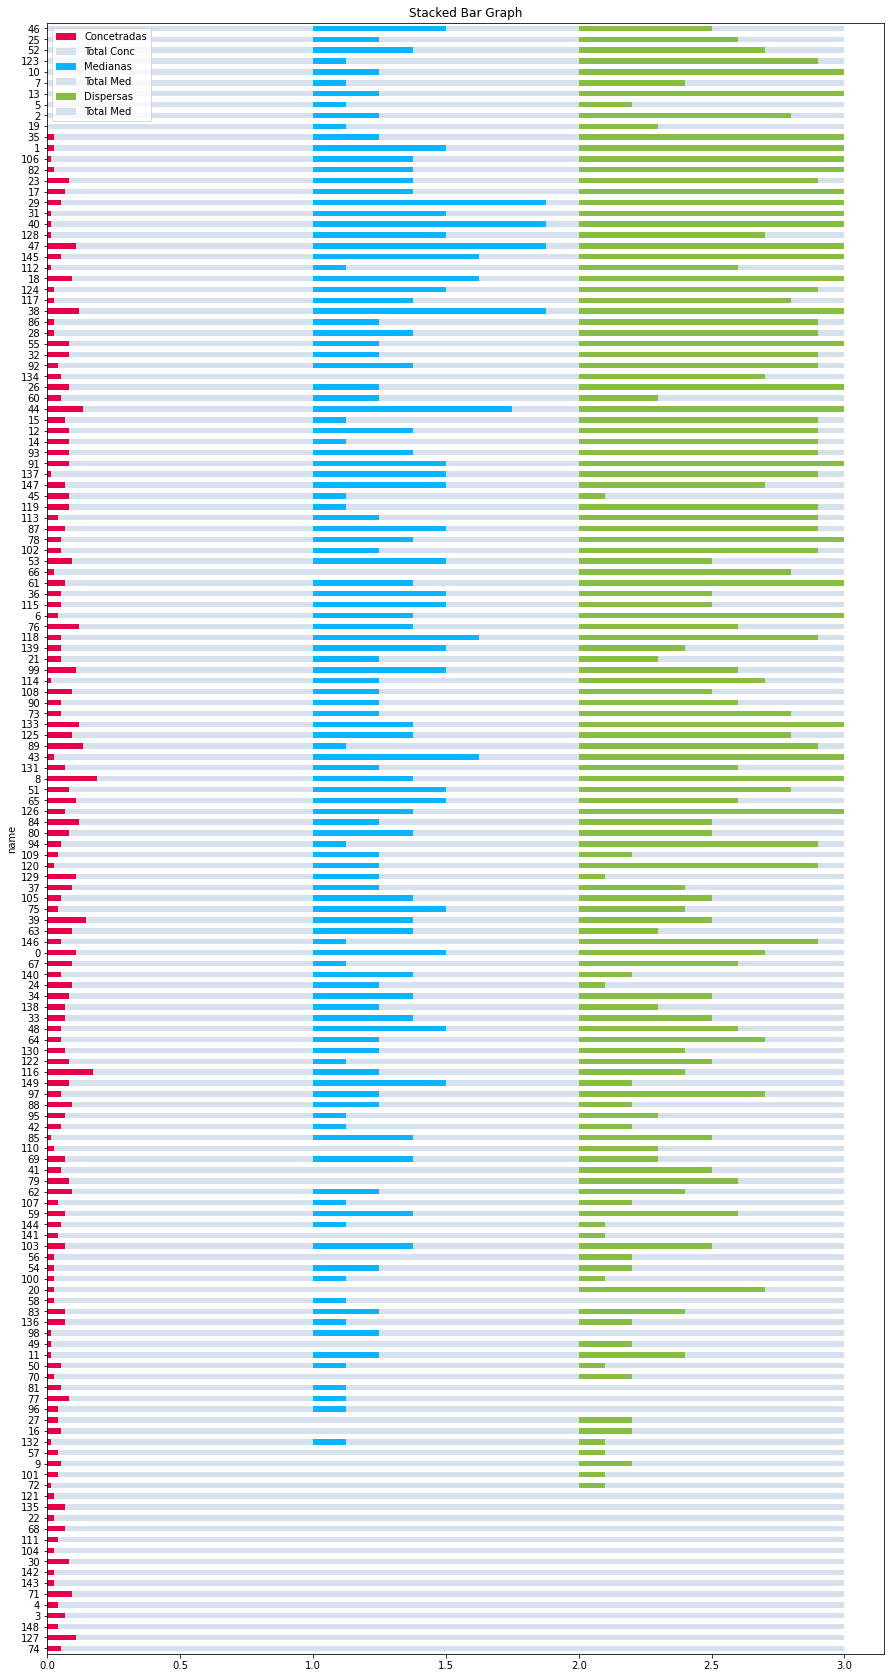

In [175]:
 #plot a Stacked Bar Graph
colors = ['#e60049', '#d7e1ee', '#0bb4ff', '#d7e1ee','#87bc45','#d7e1ee']
plt.figure(figsize=(15,30))
a.plot(
    x = "name",
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True, figsize=(15,30), color=colors)
plt.show()

In [178]:
### Resource accessed distribution by communities
# Recorresr todos los recursos y ver los usuarios que acceden al él. Detectar
# de cual tipo de comunidad atrae más usuarios.

all_types_coms = sma_comms + med_comms + big_comms # All types of communitites

 # Store the number of users in each type of community
dict_user_coms = {} # Example -> {id_res: {sma: 40, med: 12, big: 4}, ...}

for rsrc in bip_network.vs.select(typen=1):
    # Get all users "name" which accessed to the rsrc (resource)
    users_name_accessed = [i["name"] for i in rsrc.neighbors()]

    # Counters
    counter_small = 0
    counter_med = 0
    counter_big = 0
    rsr_impor_sma = rsr_impor_med = rsr_impor_big = 0    
    counter_coms = 0
    
    # Get all user in small communities
    for comty in sma_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_small += len(intersec_users)
            rsr_impor_sma += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_sma = rsr_impor_sma / counter_coms
    else:
        rsr_impor_sma = np.nan
    counter_coms = 0

    # Get all user in small communities
    for comty in med_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_med += len(intersec_users)
            rsr_impor_med += len(intersec_users) / len(users_in_com)
            counter_coms += 1
        
    if counter_coms > 0:
        rsr_impor_med = rsr_impor_med / counter_coms
    else:
        rsr_impor_med = np.nan

    counter_coms = 0

    for comty in big_comms:
        users_in_com = comty[1].vs["name"]    
        # Intersection of above lists
        intersec_users = set(users_in_com).intersection(set(users_name_accessed))
        if len(intersec_users) > 0:
            counter_big += len(intersec_users)
            rsr_impor_big += len(intersec_users) / len(users_in_com)
            counter_coms += 1

    if counter_coms > 0:
        rsr_impor_big = rsr_impor_big / counter_coms

    else:
        rsr_impor_big = np.nan
    counter_coms = 0

    total_accessed = counter_small + counter_med + counter_big
    total_rsr_impor = rsr_impor_sma + rsr_impor_med + rsr_impor_big
    # Add all counters
    dict_user_coms[rsrc["name"]] = {"impsma": rsr_impor_sma,
                                    "impmed": rsr_impor_med,
                                    "impbig": rsr_impor_big,
                                    "sma": counter_small/total_accessed}
    
#dict_user_coms

In [179]:
a = pd.DataFrame(dict_user_coms)
a = a.T
a["name"] = [str(i) for i in range(150)]
a = a.sort_values("sma", ascending=False)
a = a.drop("sma", axis=1)
a.rename(columns = {'impsma':'Concentradas', "impmed": "Medianas", "impbig":"Dispersas"}, inplace = True)
#a.impsma.replace(0, np.nan)
#a.impmed.replace(0, np.nan)
#a.impbig.replace(0, np.nan)
a

,Concentradas,Medianas,Dispersas,name
20294,0.150799,NaN,NaN,74
39879,0.157029,NaN,NaN,127
26437,0.226243,NaN,NaN,148
391,0.277817,NaN,NaN,3
29304,0.347726,NaN,NaN,4
...,...,...,...,...
3853,NaN,0.010534,0.246333,10
40069,NaN,0.024096,0.015761,123
23964,NaN,0.017666,0.018858,52
1020,NaN,0.502732,0.016415,25


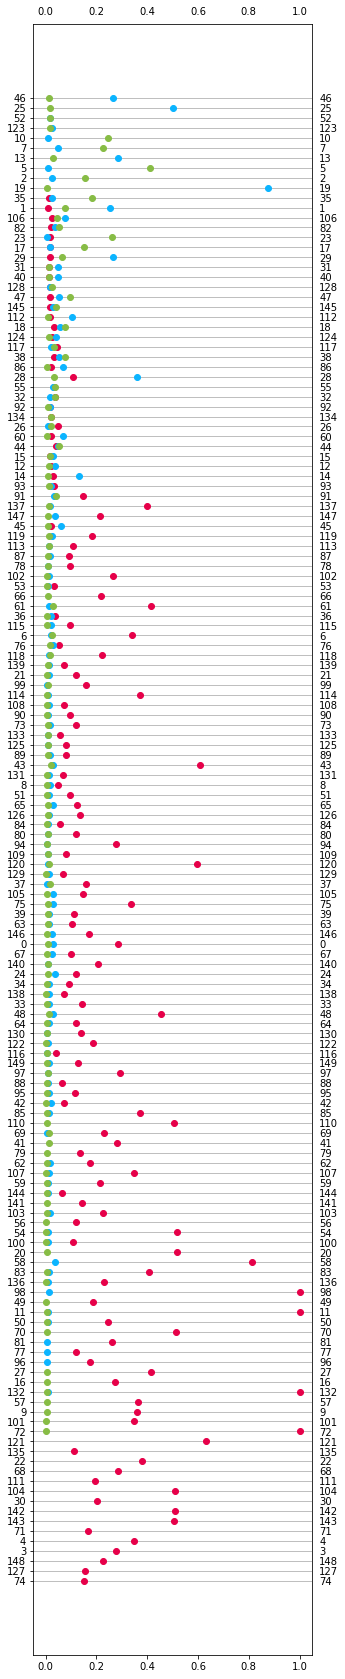

In [183]:
# Plot error bar
colors = ['#e60049', '#0bb4ff', '#87bc45']
plt.figure(figsize=(5,30))
plt.errorbar(a.Concentradas, a.name,  fmt = 'o',color = '#e60049', label=a.name,
            elinewidth = 2, capsize=10)
plt.errorbar(a.Medianas,a.name, fmt = 'o',color = '#0bb4ff', 
            ecolor = 'blue', elinewidth = 5, capsize=10, label=a.name)
plt.errorbar(a.Dispersas,a.name,fmt = 'o',color = '#87bc45', 
            ecolor = 'red', elinewidth = 5, capsize=10, label=a.name)
plt.yticks(a.name)
plt.grid(axis="y")
plt.tick_params(labelright=True, labeltop=True)
plt.show()

## Fin

In [35]:
test = bip_network.vs.select(typen=0)
bip_network.vs["cluster"] = -1
bip_network.vs["tipoC"] = -1

for user_ in test: # Loop over users in bipartite network
    # Find their node in user_network
    node_user_net = user_network.vs.find(name=user_["name"])
    user_["cluster"] = node_user_net["commty"]
    user_["tipoC"] = node_user_net["tipoCom"]

list(bip_network.vs())


[igraph.Vertex(<igraph.Graph object at 0x00000224D2513138>, 0, {'name': 9991643999, 'typen': 0, 'cluster': '0', 'tipoC': 1}),
 igraph.Vertex(<igraph.Graph object at 0x00000224D2513138>, 1, {'name': 39262, 'typen': 1, 'cluster': -1, 'tipoC': -1}),
 igraph.Vertex(<igraph.Graph object at 0x00000224D2513138>, 2, {'name': 999167999, 'typen': 0, 'cluster': '8', 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x00000224D2513138>, 3, {'name': 17308, 'typen': 1, 'cluster': -1, 'tipoC': -1}),
 igraph.Vertex(<igraph.Graph object at 0x00000224D2513138>, 4, {'name': 9997708999, 'typen': 0, 'cluster': '18', 'tipoC': 0}),
 igraph.Vertex(<igraph.Graph object at 0x00000224D2513138>, 5, {'name': 75834, 'typen': 1, 'cluster': -1, 'tipoC': -1}),
 igraph.Vertex(<igraph.Graph object at 0x00000224D2513138>, 6, {'name': 9997625999, 'typen': 0, 'cluster': '33', 'tipoC': 2}),
 igraph.Vertex(<igraph.Graph object at 0x00000224D2513138>, 7, {'name': 391, 'typen': 1, 'cluster': -1, 'tipoC': -1}),
 igraph.Verte

In [70]:
# Export Bip network with clusters id
ig.write(bip_network, "bip_with_data.graphml")

In [36]:
copy_bip = bip_network.copy()
test = copy_bip.vs.select(typen=0)

for user_ in test: # Loop over users in bipartite network
    # Find their node in user_network
    #node_user_net = user_network.vs.find(name=user_["name"])
    data_user = user_dict[user_["name"]]
    user_[user_attrs[0]] = data_user[0]
    user_[user_attrs[1]] = data_user[1]
    user_[user_attrs[2]] = data_user[2]
    user_[user_attrs[3]] = data_user[3]
    user_[user_attrs[4]] = data_user[4]
    user_[user_attrs[5]] = data_user[5]
    user_[user_attrs[6]] = data_user[6]
    user_[user_attrs[7]] = data_user[7]
    #user_["cluster"] = node_user_net["cluster"]
    #user_["tipoC"] = node_user_net["tipoCom"]

list(copy_bip.vs())


[igraph.Vertex(<igraph.Graph object at 0x00000224E4A26228>, 0, {'name': 9991643999, 'typen': 0, 'cluster': '0', 'tipoC': 1, 'MGR_ID': 16527, 'ROLE_ROLLUP_1': 91261, 'ROLE_ROLLUP_2': 118026, 'ROLE_DEPTNAME': 118202, 'ROLE_TITLE': 117905, 'ROLE_FAMILY_DESC': 117906, 'ROLE_FAMILY': 290919, 'ROLE_CODE': 117908}),
 igraph.Vertex(<igraph.Graph object at 0x00000224E4A26228>, 1, {'name': 39262, 'typen': 1, 'cluster': -1, 'tipoC': -1, 'MGR_ID': None, 'ROLE_ROLLUP_1': None, 'ROLE_ROLLUP_2': None, 'ROLE_DEPTNAME': None, 'ROLE_TITLE': None, 'ROLE_FAMILY_DESC': None, 'ROLE_FAMILY': None, 'ROLE_CODE': None}),
 igraph.Vertex(<igraph.Graph object at 0x00000224E4A26228>, 2, {'name': 999167999, 'typen': 0, 'cluster': '8', 'tipoC': 0, 'MGR_ID': 139593, 'ROLE_ROLLUP_1': 117902, 'ROLE_ROLLUP_2': 118041, 'ROLE_DEPTNAME': 119781, 'ROLE_TITLE': 130479, 'ROLE_FAMILY_DESC': 179826, 'ROLE_FAMILY': 119784, 'ROLE_CODE': 130481}),
 igraph.Vertex(<igraph.Graph object at 0x00000224E4A26228>, 3, {'name': 17308, 'typen

In [37]:
# Export Bip network with clusters id
ig.write(copy_bip, "bip_with_attrs.graphml")

In [94]:
mgr = rol1 = rol2 = dept = title = famdes = fam = rcode = []
atrs_list = ['MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
             'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY','ROLE_CODE']


In [148]:
list(range(81))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80]

In [151]:
mgr = []
rol1 = []
rol2 = []
dept = []
title = []
famdes = []
fam = []
rcode = []
atrs_list = ['MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
             'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY','ROLE_CODE']

for i in list(range(80)):
    #print(i)
    users_commty = copy_bip.vs.select(cluster=str(i))
    for atr in atrs_list:
    # Get the counter of values of an attribute
        valores_difd = Counter(users_commty[atr]).values()
        contador = max(valores_difd) / len(users_commty[atr])
        if atr == "MGR_ID":
            mgr.append(contador)
            print("a")
        elif atr == "ROLE_ROLLUP_1":
            rol1.append(contador)
            print("b")
        elif atr == "ROLE_ROLLUP_2":
            rol2.append(contador)
            print("c")
        elif atr == "ROLE_DEPTNAME":
            dept.append(contador)
            print("d")
        elif atr == "ROLE_TITLE":
            title.append(contador)
            print("e")
        elif atr == "ROLE_FAMILY_DESC":
            famdes.append(contador)
            print("f")
        elif atr == "ROLE_FAMILY":
            fam.append(contador)
            print("g")    
        elif atr == "ROLE_CODE":
            rcode.append(contador)     
            print("h")
    print("X")
    #print(len(users_commty["MGR_ID"]))
    #print(len(set(users_commty["MGR_ID"])))    

a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g


h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X


<Figure size 432x288 with 0 Axes>

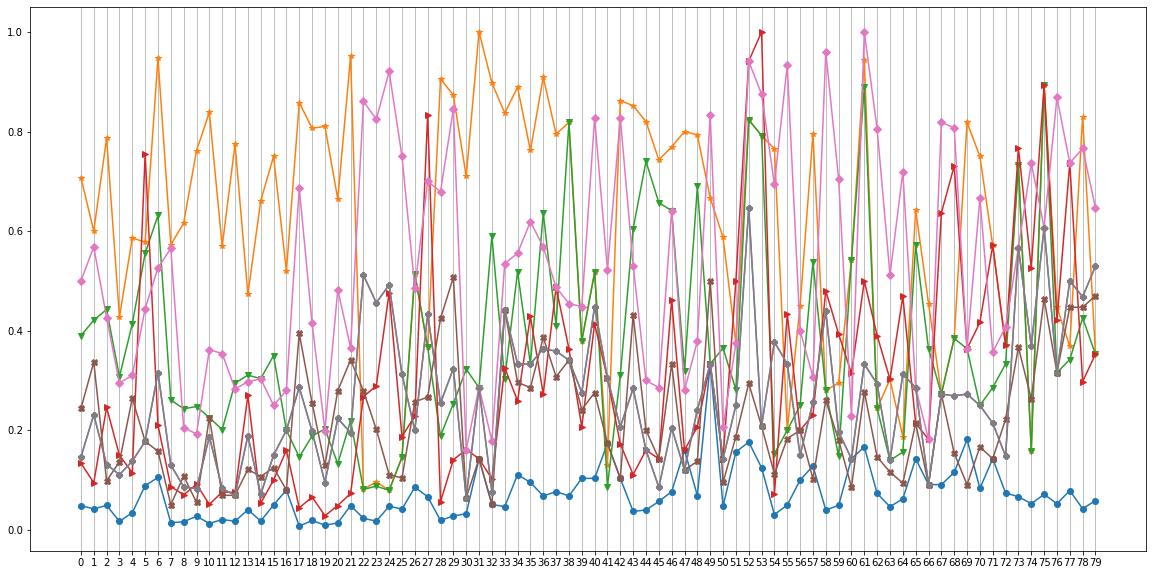

In [154]:
plt.clf()

plt.figure(figsize=(20,10))
plt.xticks(range(80))
line_style = "-"
plt.plot(range(80), mgr, marker = 'o', ls=line_style)
plt.plot( range(80),rol1,marker = '*', ls=line_style)
plt.plot(range(80), rol2, marker = 'v', ls=line_style)
plt.plot(range(80), dept, marker = '>', ls=line_style)
plt.plot(range(80), title, marker = 'p', ls=line_style)
plt.plot(range(80), famdes, marker = 'X', ls=line_style)
plt.plot(range(80), fam, marker = 'D', ls=line_style)
plt.plot(range(80), rcode, marker = 'P', ls=line_style)

plt.grid(axis="x")

plt.show()

# LINEAR SCALE

#axs[0, 0].set_title('Linear Scale')
#axs[0, 0].plot(degree_list, color='#e60049')
#axs[0, 0].set(ylabel='P(k)', xlabel='k')


In [210]:
all_user_df = df_train_k_pos[df_train_k_pos.USERID.isin(bip_network.vs.select(typen=0)["name"])].drop_duplicates()

all_user_df = all_user_df.drop(columns="RESOURCE").drop_duplicates()

#all_user_df = all_user_df[user_attrs].drop_duplicates().values.tolist()
len(all_user_df)

5436

In [179]:
import kmodes

In [211]:
###Select the number of clusters###
num_clusters = 80

#DO NOT CHANGE THIS CODE
#seed = 29
#Compute centroids and labels
num_init = 5
centroids = []
kmodes_huang = kmodes.KModes(n_clusters=num_clusters, n_init=num_init, init='Huang', verbose=0) #, random_state=seed)
cluster_labels = kmodes_huang.fit_predict(all_user_df)
centroids = kmodes_huang.cluster_centroids_

print('Ready!')    

Ready!


In [214]:
new_user_df = pd.DataFrame(all_user_df)
new_user_df.columns = atrs_list + ["USERID"]
new_user_df["cluster"] = cluster_labels
new_user_df

,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,USERID,cluster
3422,16527,91261,118026,118202,117905,117906,290919,117908,9991643999,77
18980,139593,117902,118041,119781,130479,179826,119784,130481,999167999,0
18935,44024,117961,117962,122224,120690,122225,290919,120692,9997708999,44
23073,79911,117922,117923,117941,117879,117886,19721,117880,9997625999,30
24291,25293,117961,118386,118317,121414,130802,118704,121416,9994445999,0
...,...,...,...,...,...,...,...,...,...,...
10824,15567,117961,118052,119408,118536,132799,308574,118539,9992250999,28
17616,249,117961,118225,118403,118321,117906,290919,118322,9996848999,63
23200,71387,117961,118386,118522,118784,147114,290919,118786,9998412999,40
3484,17788,117961,118446,119961,132671,118260,290919,132673,9991254999,19


In [215]:
mgr = []
rol1 = []
rol2 = []
dept = []
title = []
famdes = []
fam = []
rcode = []

for i in list(range(80)):
    #print(i)
    a = new_user_df[new_user_df.cluster==i]
    for atr in atrs_list:
    # Get the counter of values of an attribute
        valores_difd = Counter(a[atr]).values()
        contador = max(valores_difd) / len(a[atr])
        if atr == "MGR_ID":
            mgr.append(contador)
            print("a")
        elif atr == "ROLE_ROLLUP_1":
            rol1.append(contador)
            print("b")
        elif atr == "ROLE_ROLLUP_2":
            rol2.append(contador)
            print("c")
        elif atr == "ROLE_DEPTNAME":
            dept.append(contador)
            print("d")
        elif atr == "ROLE_TITLE":
            title.append(contador)
            print("e")
        elif atr == "ROLE_FAMILY_DESC":
            famdes.append(contador)
            print("f")
        elif atr == "ROLE_FAMILY":
            fam.append(contador)
            print("g")    
        elif atr == "ROLE_CODE":
            rcode.append(contador)     
            print("h")
    print("X")
    #print(len(users_commty["MGR_ID"]))
    #print(len(set(users_commty["MGR_ID"])))    

a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h


X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d
e
f
g
h
X
a
b
c
d

<Figure size 432x288 with 0 Axes>

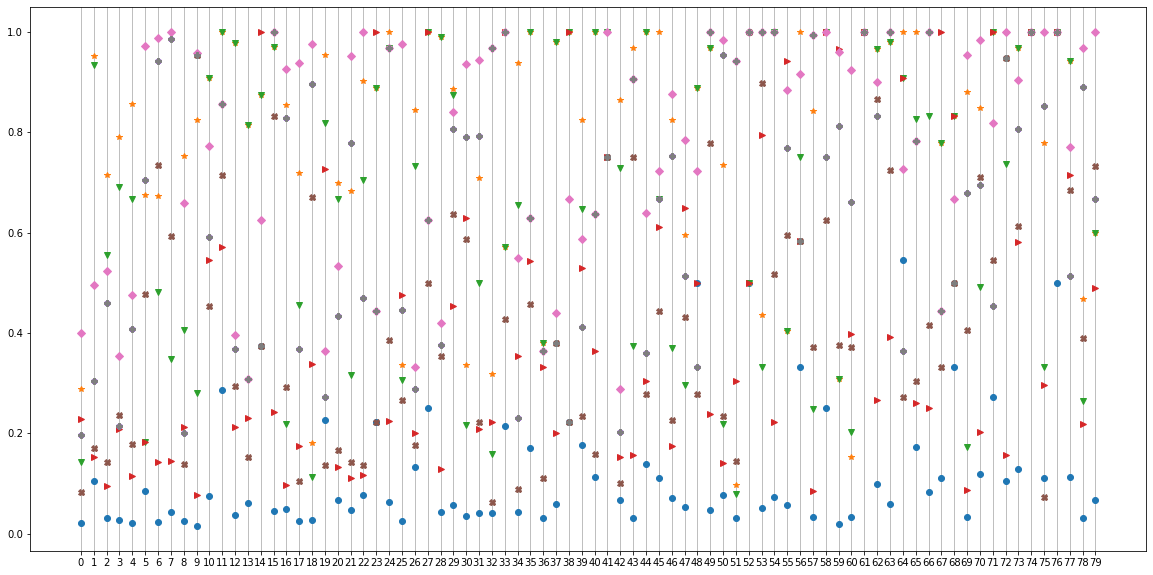

In [216]:
plt.clf()

plt.figure(figsize=(20,10))
plt.xticks(range(80))
line_style = "none"
plt.plot(range(80), mgr, marker = 'o', ls=line_style)
plt.plot( range(80),rol1,marker = '*', ls=line_style)
plt.plot(range(80), rol2, marker = 'v', ls=line_style)
plt.plot(range(80), dept, marker = '>', ls=line_style)
plt.plot(range(80), title, marker = 'p', ls=line_style)
plt.plot(range(80), famdes, marker = 'X', ls=line_style)
plt.plot(range(80), fam, marker = 'D', ls=line_style)
plt.plot(range(80), rcode, marker = 'P', ls=line_style)

plt.grid(axis="x")

plt.show()

# LINEAR SCALE

#axs[0, 0].set_title('Linear Scale')
#axs[0, 0].plot(degree_list, color='#e60049')
#axs[0, 0].set(ylabel='P(k)', xlabel='k')


In [227]:
lista_accesos_rec_cluster = []

for i in range(80):
    #print(i)
    a = new_user_df[new_user_df.cluster==i]
    a = list(a["USERID"])
    a = df_train_k_pos[df_train_k_pos.USERID.isin(a)]
    a = set(list(a["RESOURCE"]))
    #print(len(a))
    lista_accesos_rec_cluster.append(len(a))    
    #print(len(users_commty["MGR_ID"]))
    #print(len(set(users_commty["MGR_ID"])))    
len(lista_accesos_rec_cluster)

80

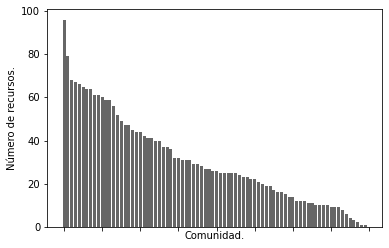

In [231]:
plt.bar(range(80), sorted(lista_accesos_rec_cluster, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('n_recursos_por_comunidad_amz.pdf')

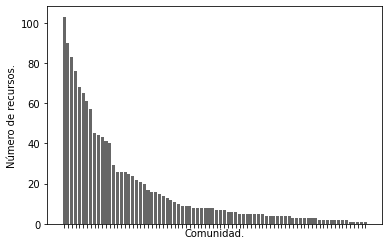

In [232]:
plt.bar(dict_commts.keys(), sorted(n_res_in_comms, reverse=True), color='0.40')
plt.ylabel('Número de recursos.')
plt.xlabel('Comunidad.')
plt.tick_params(labelbottom=False)
#plt.savefig('n_recursos_por_comunidad_amz.pdf')